<a href="https://colab.research.google.com/github/bsguedes/machine-learning/blob/master/Trabalho_Final_Equac%CC%A7%C3%B5es_no_MNIST_%5BHP%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho Final

### Projete e treine uma rede neural para efetuar um cálculo (soma, subtração, ou multiplicação) usando duas imagens do MNIST. 

Exemplos: 
* (Imagem do dígito 3) + (Imagem do dígito 5) = 8
* (Imagem do dígito 2) - (Imagem do dígito 1) = 1
* (Imagem do dígito 9) x (Imagem do dígito 5) = 45
* (Imagem do dígito 1) + (Imagem do dígito 2) = 3

Dicas: 
* A rede receberá duas entradas: um tensor contento duas imagens, e outro tensor contendo um inteiro que representa a operação
* A saída sempre será um número inteiro 
* Os índices das operações são os seguintes: 0 - Soma, 1 - Subtração, 2 - Multiplicação
* Pense em uma forma de transformar os inteiros que representam as operações em vetores

In [0]:
%matplotlib inline

### Atenção: Rode esta linha apenas se estiver usando o Google Colab

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

    100% |████████████████████████████████| 91.1MB 148.8MB/s 
    100% |████████████████████████████████| 2.0MB 6.1MB/s 
fastai 0.7.0 has requirement torch<0.4, but you'll have torch 0.4.1 which is incompatible.


In [0]:
import torch
from torch import nn
from torch import optim
import torchvision
from matplotlib import pyplot as plt
from torchvision import transforms
from torchvision import datasets

### O código das célula abaixo contém funções para efetuar a carga dos dados, treinamento e teste dos modelos

In [0]:
def train(
        model,
        train_loader,
        test_loader,
        device,
        lr,
        nb_epochs=3,
        log_interval=100,
    ):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss().to(device)

    print('\n* * * Evaluating * * *')
    acc = test(model, device, criterion, test_loader)
    
    for epoch in range(1, nb_epochs + 1):
        print('\n* * * Training * * *')
        train_epoch(
            model=model, 
            device=device, 
            train_loader=train_loader, 
            optimizer=optimizer, 
            criterion=criterion, 
            epoch=epoch, 
            log_interval=log_interval
        )
        print('\n* * * Evaluating * * *')
        acc = test(model, device, criterion, test_loader)
    
    return acc



In [0]:
def get_loaders(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_loader = torch.utils.data.DataLoader(
        dataset=datasets.MNIST(
            root='../data', 
            train=True, 
            download=True,
            transform=transform,
        ),
        batch_size=batch_size, 
        shuffle=True,
        collate_fn=collate_fn
    )

    test_loader = torch.utils.data.DataLoader(
        dataset=datasets.MNIST(
            root='../data', 
            train=False, 
            download=True,
            transform=transform,
        ),
        batch_size=batch_size, 
        shuffle=True,
        collate_fn=collate_fn
    )
    return train_loader, test_loader



In [0]:
from collections import OrderedDict
operators = OrderedDict({
    '': -1,
    '+': 0,
    '-': 1,
    '*': 2,
})

n_operators = len(operators)-1
operators_i2o = {v: k for k, v in operators.items()}

In [0]:
def collate_fn(data):
    digits, labels = zip(*data)
    digits = torch.stack(digits, 0).float()
    labels = torch.stack(labels, 0)
    
    digits_idxs_mask = sample_digits(digits, 2)
    
    new_data = digits[digits_idxs_mask]
    digit_targets = labels[digits_idxs_mask]
    
    sampled_ops = sample_operators(len(new_data), 1, total_ops=3)
    target, equation_str = make_ground_truth(digit_targets, sampled_ops)

    return new_data, target, equation_str, sampled_ops

In [0]:
def sample_digits(data, n_digits):
    N = data.shape[0]
    clear_diag = (1-torch.eye(N, N))
    prob_matrix = clear_diag * torch.empty(N, N).uniform_(0, 1)
    return torch.multinomial(prob_matrix, n_digits)

In [0]:
def sample_operators(n_samples, sample_n_ops, total_ops=3):
    return torch.multinomial(torch.empty(n_samples, total_ops).uniform_(0, 1), sample_n_ops)

In [0]:
def make_ground_truth(digit_targets, sampled_ops):
    
    result_targets = []
    result_equations = []
    
    for ds, op in zip(digit_targets, sampled_ops):
        op = torch.cat([op, -torch.ones(1).long()])
        
        equation = ''.join(['{}{}'.format(d, operators_i2o[o.item()]) for d, o in zip(ds, op)])
        result_equations.append(equation)
        result = eval(equation)
        result_targets.append(result)
    
    return torch.LongTensor(result_targets)+9, result_equations
    

In [0]:
def plot_instances(new_data, operators, pred_scores, nb_inst=5):
    fig, axes = plt.subplots(nb_inst, 2, )
    for i in range(nb_inst):
        axs = axes[i]
        data = new_data[i]
        ops = operators[i]
        pred = pred_scores[i]
        for digit, ax in zip(data, axs):
            digit = digit.cpu().permute(1, 2, 0).squeeze()        
            ax.imshow(digit, cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])
        ax.text(-50, 15, operators_i2o[ops[0].item()], fontsize=24)
        ax.text(30, 15, '={}'.format(pred.cpu().numpy()-9), fontsize=24)    
    

In [0]:
def train_epoch(
        model, 
        device, 
        train_loader, 
        optimizer, 
        criterion, 
        epoch, 
        log_interval
    ):
    model.train()
    history = []
    for batch_idx, data in enumerate(train_loader):
        data, target, eq_str, sampled_ops = data
        data = data.to(device)
        target = target.to(device)
        sampled_ops= sampled_ops.to(device)
        
        optimizer.zero_grad()
        output = model(digits=data, ops=sampled_ops)

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))



In [0]:
def test(
        model, 
        device, 
        criterion, 
        test_loader, 
        plot_images=True
    ):
    model.eval()
    test_loss = 0
    correct = 0
    mse_loss = nn.MSELoss()
    total_mse = 0
    with torch.no_grad():
        for data, target, eq_str, sampled_ops in test_loader:
    
            data = data.to(device)
            target = target.to(device)
            sampled_ops= sampled_ops.to(device)
            
            output = model(digits=data, ops=sampled_ops)
            test_loss += criterion(output, target).item() # sum up batch loss                        
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            
            total_mse += mse_loss(pred.float().squeeze(), target.float()).item()
            correct += pred.eq(target.view_as(pred)).sum().item()
            
        plot_instances(new_data=data, operators=sampled_ops, pred_scores=pred)            
            
        
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('Test set:\nAverage loss: {:.4f}\nAccuracy: {}/{} ({:.2f}%)\nErro Médio: {:.2f}\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy, total_mse))
    return accuracy

### Hyper-parâmetros que você pode definir

In [0]:
batch_size = 16
device_name = 'cpu'
nb_epochs = 10
log_interval = 50
lr = 1e-3

In [0]:
device = torch.device(device_name)

### Conferência dos dados

#### Entrada da rede: digits=(batch, num_digitos, canais, altura, largura), ops=(batch, operador) 
* num_digitos=2
* canais=1
* altura
* largura=28

### Operadores 
* -1) Nenhum
* 0) Soma (`+`)
* 1) Subtração (`-`)
* 2) Multiplicação (`*`)

Processing...
Done!


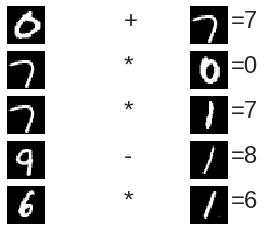

In [0]:
train_loader, test_loader = get_loaders(batch_size=batch_size)
digit_images, eq_target, eq_str, operator_ids = next(iter(train_loader))

plot_instances(digit_images, operator_ids, eq_target)

In [0]:
print('Dados de entrada na rede:')
print('Imagens   : ', digit_images.shape)
print('Operadores: ', operator_ids.shape)
print('... Ex Ops: ', operator_ids[:5].numpy().tolist(), operators)
print('Classes   : ', eq_target.shape)
print('... Ex Cls: ', eq_target[:5].numpy().tolist())

Dados de entrada na rede:
('Imagens   : ', torch.Size([16, 2, 1, 28, 28]))
('Operadores: ', torch.Size([16, 1]))
('... Ex Ops: ', [[0], [2], [2], [1], [2]], OrderedDict([('', -1), ('+', 0), ('*', 2), ('-', 1)]))
('Classes   : ', torch.Size([16]))
('... Ex Cls: ', [16, 9, 16, 17, 15])


## Seu trabalho começa aqui

### 1) Implemente uma rede capaz de compreender o conteúdo das imagens do MNIST.

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class DigitsConvNet(nn.Module):
    def __init__(self):
        super(DigitsConvNet, self).__init__()
        conv_1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        pool = nn.MaxPool2d(kernel_size=2)
        relu = nn.ReLU(inplace=True)        
        conv_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        f = Flatten()        
        self.conv = nn.Sequential(*[conv_1, relu, pool, conv_2, relu, pool, f])
        
    def forward(self, x):        
        x = self.conv(x)        
        return x

In [31]:
net = DigitsConvNet()

print(net)
pred = net(torch.zeros(5, 1, 28, 28))
print(pred.shape)

assert pred.shape[0] == 5 and len(pred.shape) == 2
print('Passed! Go to the next step.')

DigitsConvNet(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten()
  )
)
torch.Size([5, 3136])
Passed! Go to the next step.


### 2) Implemente uma rede neural capaz de resolver uma operação matemática entre duas imagens do MNIST. 
* **DICA**: Utilize a DigitsConvNet como um módulo dentro da EquationNet para extrair vetores de características de todas as imagens.

In [0]:
class EquationNet(nn.Module):
    def __init__(self):
        super(EquationNet, self).__init__()
        self.digitsConvNet = DigitsConvNet()
        self.lstm = nn.LSTM(input_size=3136, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64, 91)
        
    def forward(self, digits, ops):
        '''
        Arguments:
            digits (FloatTensor): cada linha contém duas imagens do MNIST. 
                                  Shape esperado: (batch, 2, 1, 28, 28)
            ops (LongTensor): cada linha contém uma operação representada em formato de números inteiros (batch, 1).
                              Shape esperado: (batch, 1)  
        Return: 
            result (FloatTensor): cada linha [i] contém o resultado da operação ops[i] 
                    aplicada entre as duas imagens digits[i]. 
                    Note que a resposta deve ser discreta, isto é, representada através de um neurônio. 
                    Shape esperado: (batch, 91)
        '''
        batch, time_steps, channels, h, w = digits.shape               
        digits = torch.cat([digits, torch.zeros(batch, 1, 1, h, w)], 1)
        time_steps += 1
        digits[:,2,:,:,:] = digits[:,1,:,:,:]                
        for i in range(batch):
          digits[i,1,:,:,:] = ops[i].float()        
        x_flat = digits.view(batch * time_steps, channels, h, w)
        features = self.digitsConvNet(x_flat)
        features = features.view(batch, time_steps, -1)        
        out, (h, c) = self.lstm(features)
        out = out[:,-1,:]
        out = self.fc(out)
        return out

In [76]:
model = EquationNet().to(device)
print(model)

# Init dummy data
dummy_digits = torch.zeros(5, 2, 1, 28, 28).to(device)
dummy_operators = torch.zeros(5, 1).long().to(device)
# Forward 
dummy_pred = model(digits=dummy_digits, ops=dummy_operators)

EquationNet(
  (digitsConvNet): DigitsConvNet(
    (conv): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Flatten()
    )
  )
  (lstm): LSTM(3136, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=91, bias=True)
)


In [77]:
# Check network's input and output
assert dummy_pred.shape == (5, 91), 'Expected: (5, 91), Found: {}'.format(dummy_pred.shape)
print('Passed')

Passed


### 3) Treine seu modelo por algumas épocas e reporte o resultado. 
* **Dica**: com uma rede leve, em 4 épocas, é possível alcançar acurácia de >=95%, e um erro médio <=1500. 


* * * Evaluating * * *
Test set:
Average loss: 0.2815
Accuracy: 377/10000 (3.77%)
Erro Médio: 305738.50


* * * Training * * *
Train Epoch: 1 [0/60000 (0%)]	Loss: 4.515853
Train Epoch: 1 [800/60000 (1%)]	Loss: 3.583863
Train Epoch: 1 [1600/60000 (3%)]	Loss: 3.594681
Train Epoch: 1 [2400/60000 (4%)]	Loss: 3.877745
Train Epoch: 1 [3200/60000 (5%)]	Loss: 3.686693
Train Epoch: 1 [4000/60000 (7%)]	Loss: 3.649952
Train Epoch: 1 [4800/60000 (8%)]	Loss: 3.139649
Train Epoch: 1 [5600/60000 (9%)]	Loss: 3.470150
Train Epoch: 1 [6400/60000 (11%)]	Loss: 3.408695
Train Epoch: 1 [7200/60000 (12%)]	Loss: 2.773246
Train Epoch: 1 [8000/60000 (13%)]	Loss: 3.298242
Train Epoch: 1 [8800/60000 (15%)]	Loss: 3.204836
Train Epoch: 1 [9600/60000 (16%)]	Loss: 3.251966
Train Epoch: 1 [10400/60000 (17%)]	Loss: 3.197397
Train Epoch: 1 [11200/60000 (19%)]	Loss: 3.369042
Train Epoch: 1 [12000/60000 (20%)]	Loss: 3.929982
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.755708
Train Epoch: 1 [13600/60000 (23%)]	Loss: 3.1378

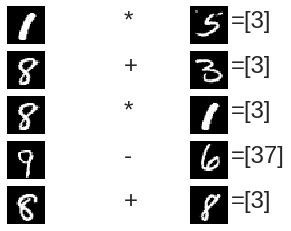

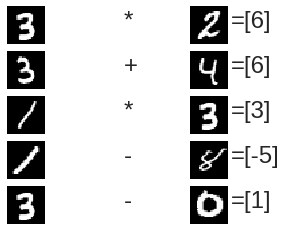

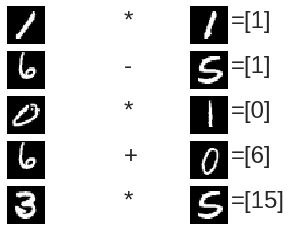

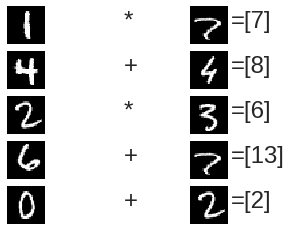

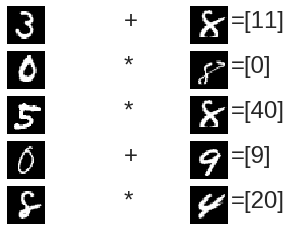

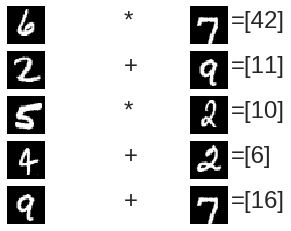

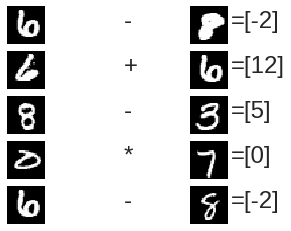

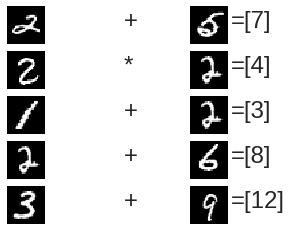

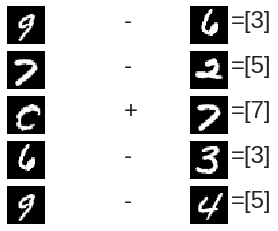

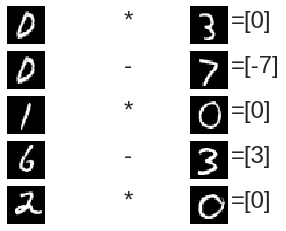

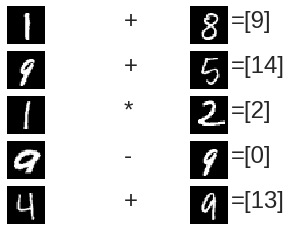

In [78]:
acc = train(model, train_loader, test_loader, device, lr, nb_epochs, log_interval)
print('Final acc: {:.2f}%'.format(acc))